In [2]:
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

from scipy.stats import multivariate_normal

In [3]:
import statsmodels as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.base.datetools import dates_from_str

# Example (but real) data from the statsmodel database
mdata = sm.datasets.macrodata.load_pandas().data

# prepare the dates index
dates = mdata[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]
quarterly = dates_from_str(quarterly)

mdata = mdata[['realgdp','realcons','realinv']]
mdata.index = pd.DatetimeIndex(quarterly)
data = np.log(mdata).diff().dropna()

#### Let the true DGP be an estimated VAR with `true_lag` number of lags

In [4]:
true_lag = 3

model = tsa.VAR(data)
results = model.fit(true_lag)

In [5]:
M = len(results.names)
L = results.k_ar
mu = results.intercept
A = results.coefs    

error = np.asarray(results.resid)
T = error.shape[0]
Sigma = (error.T @ error)/T

In [6]:
def stationary_dist(mu, A, Sigma):

    M, L = A.shape[2], A.shape[0] 
    K = M*L
    
    mu_comp = np.zeros((K, 1))
    mu_comp[:M, 0] = mu
    A_row = np.hstack([A[i, :, :] for i in range(L)])
    A_comp = np.vstack([A_row, 
                        np.hstack([np.eye(M*(L-1)), np.zeros((M*(L-1), M))])])
    Sigma_comp = np.zeros((M*L, M*L))
    Sigma_comp[:M, :M] = Sigma

    mu_stationary = np.linalg.solve(np.eye(K) - A_comp, mu_comp)
    Sigma_stationary = sp.linalg.solve_discrete_lyapunov(A_comp, Sigma_comp)

    return mu_stationary, Sigma_stationary

In [7]:
# data generating process
def true_model(N, mu, A, Sigma):
    '''Simulating the true model'''
    
    M, L = A.shape[2], A.shape[0] 
    K = M*L
    
    mu_stationary, Sigma_stationary = stationary_dist(mu, A, Sigma)
        
    initial_x = multivariate_normal(mu_stationary.squeeze(), Sigma_stationary).rvs()
    shocks = multivariate_normal(np.zeros(len(mu)), Sigma)
    error = shocks.rvs(N - L).T
    
    X = np.zeros((M, N))
    X[:, :L] = initial_x.reshape(L, M).T
    
    for t in range(N - L):
        AX = np.zeros((M, 1))
        for lag in range(L):
            AX += A[lag, :, :] @ X[:, t + L - 1 - lag].reshape(M, 1)
        X[:, L + t] = (mu.reshape(M, 1) + AX + error[:, t].reshape(M, 1)).squeeze()
    
    return pd.DataFrame(data = X.T, index = data.index[-N:])

In [8]:
#----------------------------------------------------------
# Construct the stationary distribution for the plot
#----------------------------------------------------------

mu_stationary, Sigma_stationary = stationary_dist(mu, A, Sigma)
std_stationary = np.sqrt(np.diag(Sigma_stationary[:M]))

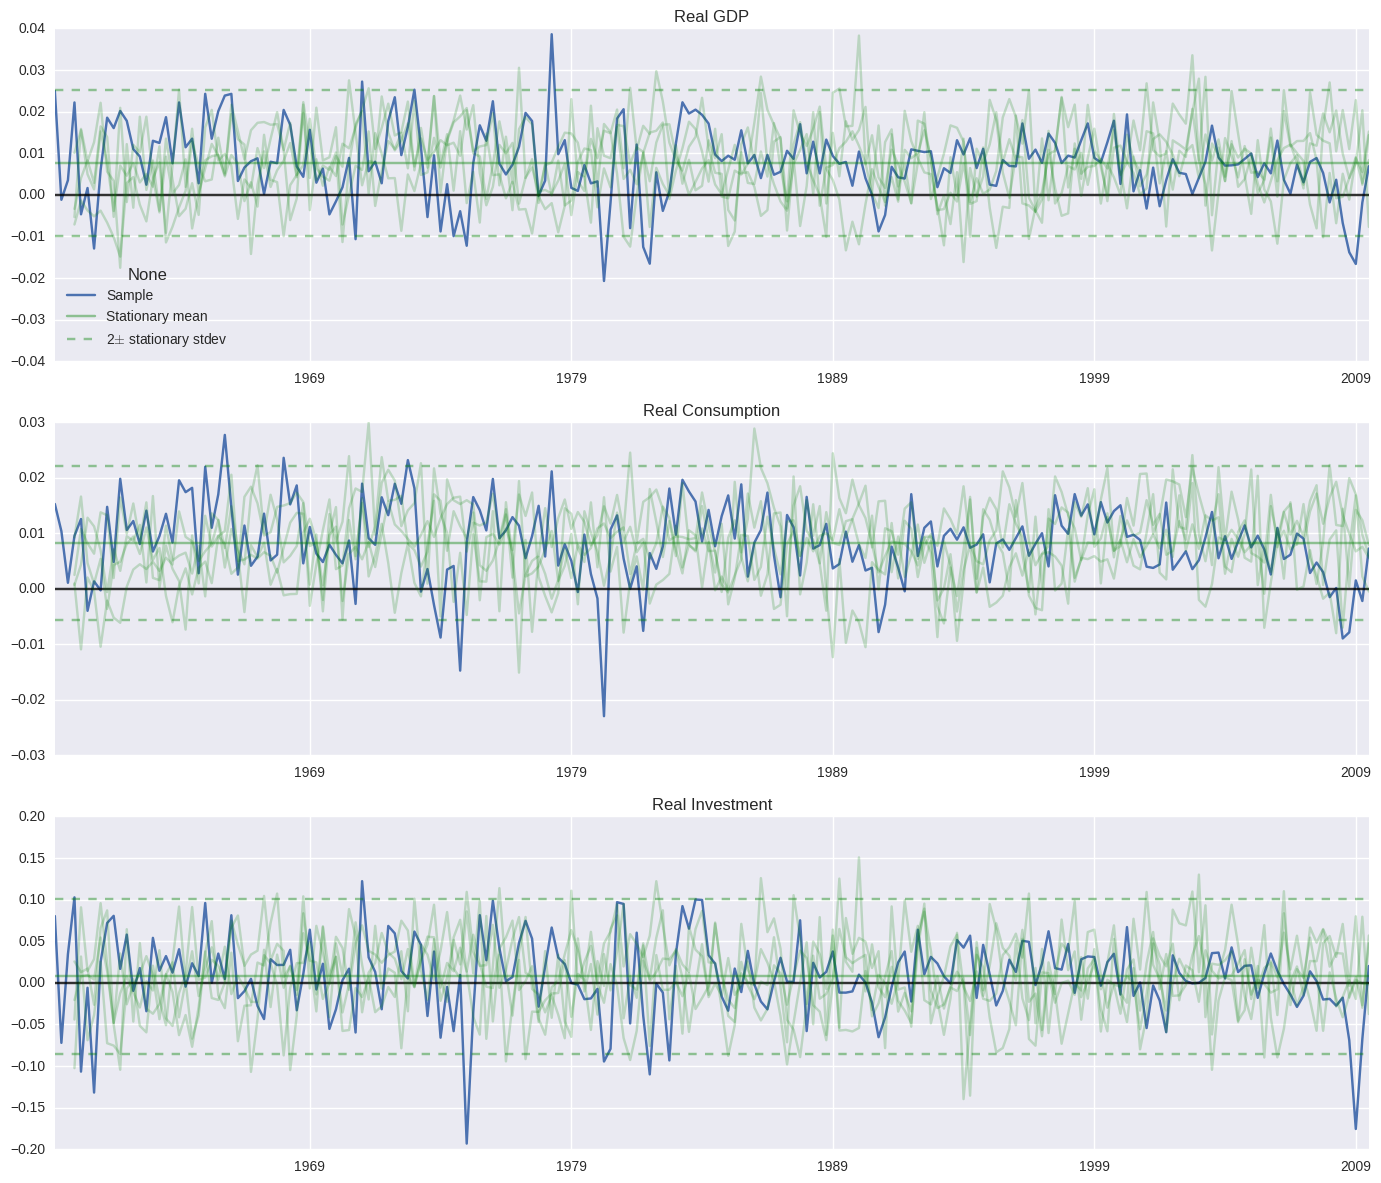

In [9]:
fig, ax = plt.subplots(3, 1, figsize = (14, 12))
data['realgdp'].plot(ax = ax[0], color = sb.color_palette()[0], label = 'Sample')
ax[0].set_title('Real GDP')
ax[0].axhline(mu_stationary[0], color = 'g', alpha = .4, label = 'Stationary mean')
ax[0].axhline(mu_stationary[0] + 2*std_stationary[0], linestyle = '--', color = 'g', 
              alpha = .4, label = r'2$\pm$ stationary stdev')
ax[0].axhline(0, color = 'k', alpha = .8)
ax[0].axhline(mu_stationary[0] - 2*std_stationary[0], linestyle = '--', color = 'g', alpha = .4)
ax[0].set_ylim([-.04, .04])
ax[0].legend(loc = 'best')

data['realcons'].plot(ax = ax[1], color = sb.color_palette()[0])
ax[1].set_title('Real Consumption')
ax[1].axhline(0, color = 'k', alpha = .8)
ax[1].axhline(mu_stationary[1], color = 'g', alpha = .4, label = 'mu_stationary')
ax[1].axhline(mu_stationary[1] + 2*std_stationary[1], linestyle = '--', color = 'g', alpha = .4)
ax[1].axhline(mu_stationary[1] - 2*std_stationary[1], linestyle = '--', color = 'g', alpha = .4)

data['realinv'].plot(ax = ax[2], color = sb.color_palette()[0])
ax[2].set_title('Real Investment')
ax[2].axhline(0, color = 'k', alpha = .8)
ax[2].axhline(mu_stationary[2], color = 'g', alpha = .4, label = 'mu_stationary')
ax[2].axhline(mu_stationary[2] + 2*std_stationary[2], linestyle = '--', color = 'g', alpha = .4)
ax[2].axhline(mu_stationary[2] - 2*std_stationary[2], linestyle = '--', color = 'g', alpha = .4)
ax[2].set_ylim([-.2, .2])

for i in range(4):
    simul = true_model(T, mu, A, Sigma)
    simul[0].plot(ax=ax[0], color = 'g', alpha = .2)
    simul[1].plot(ax=ax[1], color = 'g', alpha = .2)
    simul[2].plot(ax=ax[2], color = 'g', alpha = .2)

plt.tight_layout()
plt.savefig('./alternative_samples.png')

In [10]:
def Ezz_inv_gen(lag, mu, A, Sigma):
    """
    Generates the population moment E[\tilde{z}\tilde{z}'] and calculates its inverse
    """
    M, L = Sigma.shape[0], lag 
    La = A.shape[0]
    K = M*L
    
    mu_comp = np.zeros((K, 1))
    mu_comp[:M, 0] = mu
    A_row = np.hstack([A[i, :, :] for i in range(La)])
    
    if lag > La:
        A_row2 = np.hstack([A_row, np.zeros((M, M*(lag-La)))])
    elif lag == La:
        A_row2 = A_row
    
    A_comp = np.vstack([A_row2, 
                        np.hstack([np.eye(M*(L-1)), np.zeros((M*(L-1), M))])])
    Sigma_comp = np.zeros((K, K))
    Sigma_comp[:M, :M] = Sigma

    mu_stationary = np.linalg.solve(np.eye(K) - A_comp, mu_comp)
    Sigma_stationary = sp.linalg.solve_discrete_lyapunov(A_comp, Sigma_comp)

    Ezz = np.vstack([np.hstack([[[1]], mu_stationary.T]),
                 np.hstack([mu_stationary, Sigma_stationary])])

    return np.linalg.inv(Ezz)

In [11]:
def comparison(N, lags, M=3, finite_adj=False):
    """
    N       : effective sample size (number of dependend obs)
    lags    : list containg the number of lags for which we calculate relative se
         
         => sample size used for the calculation is N + lag
    """
    
    store_relative_se = []
    store_true_se = []
    store_asympt_se = []
        
    for lag in lags:
        X_test = true_model(N + lag, mu, A, Sigma)
        var_test = tsa.VAR(X_test)
        result_test = var_test.fit(lag)
        
        if finite_adj:
            k = 1 + M*lag
        else:
            k = 0

        #-------------------------------------------------
        # (1) Asymptotic standard errors (Hamilton p.298-299)
        #-------------------------------------------------
        residuals = np.asarray(result_test.resid)
        Omega_hat = (residuals.T @ residuals)/(N-k)

        storeX = np.asarray(X_test)
        XX = np.ones((N, 1+lag*M))
        for j in range(lag):
            XX[:, j*M+1:(j+1)*M+1] = storeX[lag-(j+1):-(j+1), :]
        Q_hat = (XX.T @ XX)/N

        se_asympt = np.sqrt(np.diag(np.kron(Omega_hat, np.linalg.inv(Q_hat)))/N)
        store_asympt_se.append(se_asympt)
        
        #-------------------------------------------------
        # (2) True standard error (using MC)
        #-------------------------------------------------
        nn = 1000
        store = np.zeros((nn, M*(M*lag + 1))) 

        for j in range(nn):
            var = tsa.VAR(true_model(N + lag, mu, A, Sigma))
            res = var.fit(lag)
            store[j, :] = np.asarray(res.params).T.flatten()
            
        se_MC = store.std(0)
        store_true_se.append(se_MC)
        
        #-------------------------------------------------
        # Relative standard values
        #-------------------------------------------------        
        store_relative_se.append(se_MC/se_asympt)
        print("Done with lag = {l}".format(l=lag))
    
    return store_relative_se, store_true_se, store_asympt_se 

In [12]:
np.random.seed(123)

In [13]:
lags = [3, 8, 15]
relative_se, true_se, asympt_se = comparison(100, lags)
relative_se_adj, true_se_adj, asympt_se_adj = comparison(100, lags, finite_adj=True)

store_AS = []
for ll in lags:
    store_AS.append(np.sqrt(np.diag(np.kron(Sigma, Ezz_inv_gen(ll, mu, A, Sigma)))/100))

Done with lag = 3
Done with lag = 8
Done with lag = 15
Done with lag = 3
Done with lag = 8
Done with lag = 15


/home/szokeb/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in sqrt


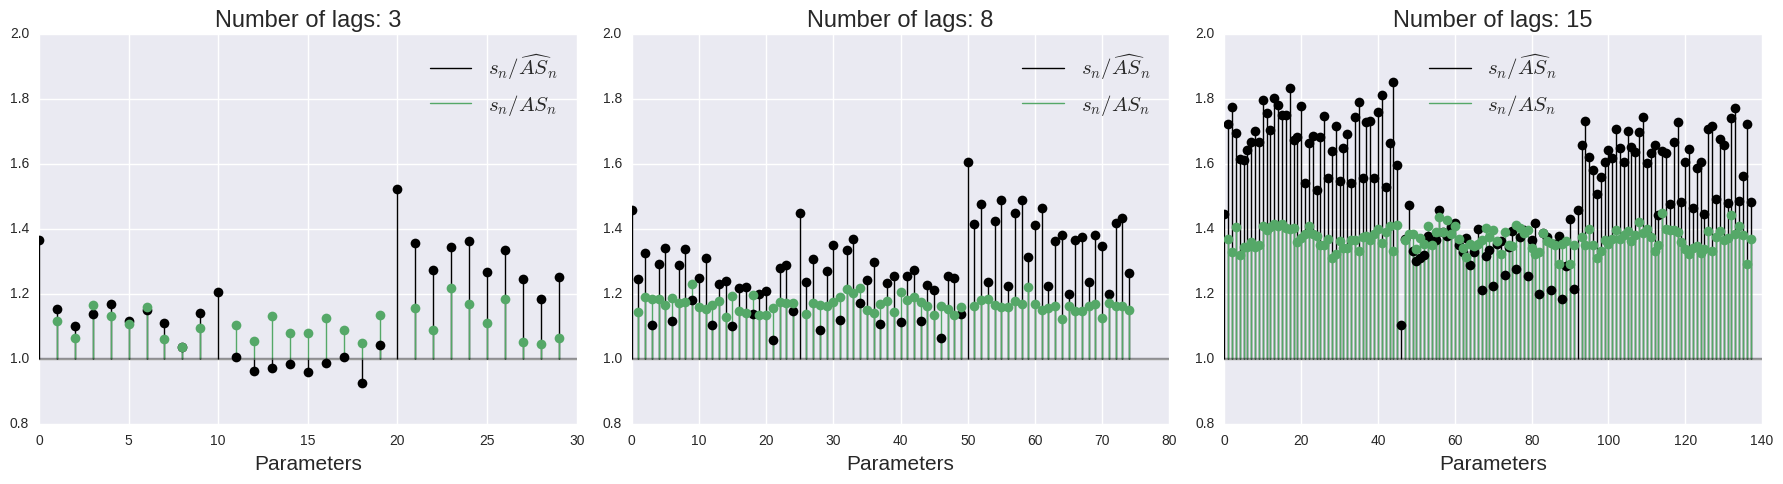

In [23]:
fig, ax = plt.subplots(1, 3, figsize = (18, 5))
cols = sb.color_palette()

for i, lag in enumerate(lags):
    Mlag = M*(M*lag + 1)
    ax[i].plot(np.arange(Mlag), relative_se[i], 'o', color = 'k')
    ax[i].vlines(np.arange(Mlag), 1, relative_se[i], lw = 1, label = r'$s_n/\widehat{AS}_n$')
    ax[i].plot(np.arange(Mlag), true_se[i]/store_AS[i], 'o', color = cols[1])
    ax[i].vlines(np.arange(Mlag), 1, true_se[i]/store_AS[i], color = cols[1], lw = 1, label = r'$s_n/AS_n$')
    ax[i].axhline(y = 1, color = 'k', alpha = .4)
    ax[i].set_title('Number of lags: {l}'.format(l=lag), fontsize = 17)
    ax[i].set_ylim([.8, 2.0])
    ax[i].set_xlabel('Parameters', fontsize = 15)
    ax[i].legend(loc = 'best', fontsize = 15)
plt.tight_layout()
plt.savefig("./relative_se1.png")

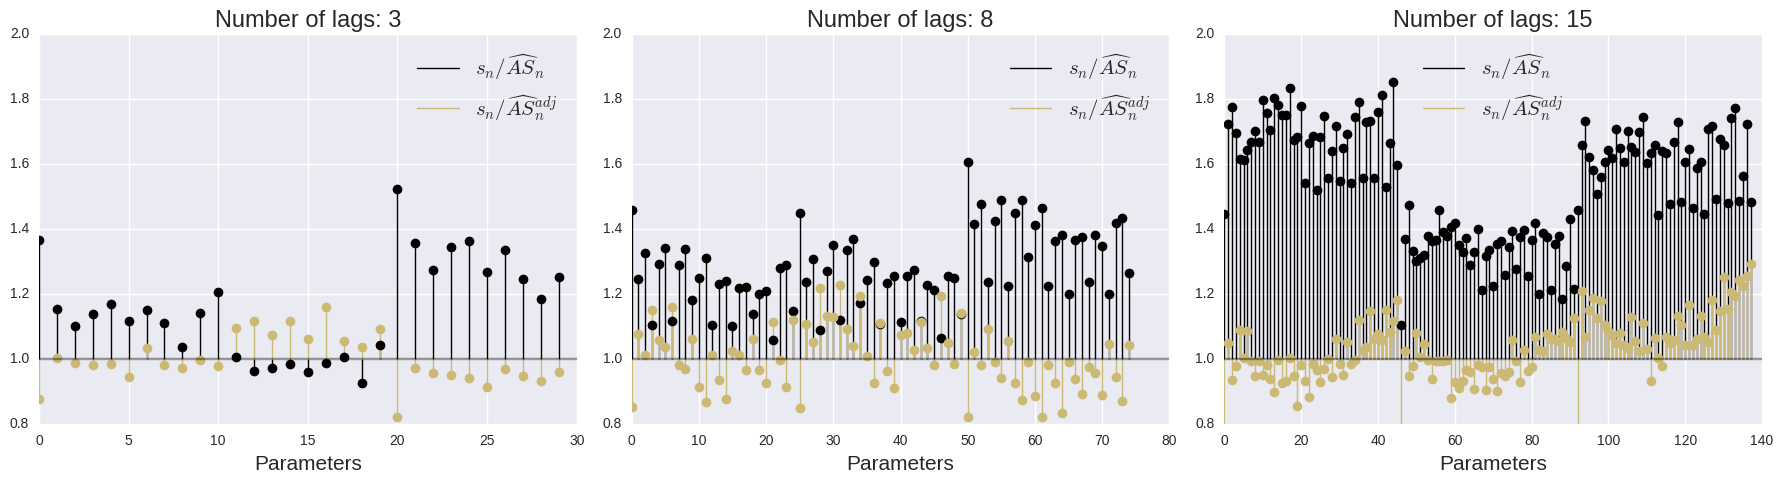

In [27]:
fig, ax = plt.subplots(1, 3, figsize = (18, 5))
cols = sb.color_palette()

for i, lag in enumerate(lags):
    Mlag = M*(M*lag + 1)
    ax[i].plot(np.arange(Mlag), relative_se[i], 'o', color = 'k')
    ax[i].vlines(np.arange(Mlag), 1, relative_se[i], lw = 1, label = r'$s_n/\widehat{AS}_n$')
    ax[i].plot(np.arange(Mlag), relative_se_adj[i], 'o', color = cols[4])
    ax[i].vlines(np.arange(Mlag), 1, relative_se_adj[i], color = cols[4], lw = 1, label = r'$s_n/\widehat{AS}^{adj}_n$')
    ax[i].axhline(y = 1, color = 'k', alpha = .4)
    ax[i].set_title('Number of lags: {l}'.format(l=lag), fontsize = 17)
    ax[i].set_ylim([.8, 2.0])
    ax[i].set_xlabel('Parameters', fontsize = 15)
    ax[i].legend(loc = 'best', fontsize = 15)
plt.tight_layout()
plt.savefig("./relative_se2.png")

fig, ax = plt.subplots(3, 2, figsize = (15, 10))

for i, lag in enumerate(lags):
    Mlag = M*(M*lag + 1)
    row, col = int(i/2), i % 2
    ax[row, col].plot(np.arange(Mlag), relative_se[i], 'o', color = 'k')
    ax[row, col].vlines(np.arange(Mlag), 1, relative_se[i], lw = 1)
    ax[row, col].plot(np.arange(Mlag), relative_se_adj[i], 'o', color = 'y')
    ax[row, col].vlines(np.arange(Mlag), 1, relative_se_adj[i], color = 'y', lw = 1)
    ax[row, col].axhline(y = 1, color = 'k', alpha = .4)
    ax[row, col].set_title('Number of lags: {l}'.format(l=lag))
    if i < 5:
        ax[row, col].set_ylim([.5, 1.7])